# Expand the dataset by classifying using Mobilenetv2

## 2024-06-28

In [1]:
import cv2
import os
import json
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [3]:
import tensorflow as tf
import keras

tf.random.set_seed(42)
keras.backend.clear_session()

2024-08-01 16:52:15.423461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 16:52:15.440820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:52:15.464602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:52:15.464631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 16:52:15.480027: I tensorflow/core/platform/cpu_feature_gua

In [4]:
# my_list = ["discocyte","echinocyte", "granular", "holly_leaf", "sickle"]
# root_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_predicted_50001"
# for items in my_list:
#     path = os.path.join(root_path, items)
#     os.mkdir(path)

Confirm prediction accurancy on only cytopix data

In [5]:
f = open(
    "/home/t.afanasyeva/deep_learning_anaemias/resources/annotations/240627_23-714262.json"
)
annotations = json.load(f)
ground_truth = annotations["annotations"][:2053]
image_ids = [record["image_id"] for record in ground_truth]
labels_tuples = [(record["image_id"], record["category_id"]) for record in ground_truth]
images = annotations["images"]
file_names_tuples = [
    (record["id"], record["file_name"])
    for record in images
    if record["id"] in image_ids
]

file_name_labels_dict = {}
for file_name in file_names_tuples:
    for label in labels_tuples:
        if file_name[0] == label[0]:
            file_name_labels_dict[file_name[1]] = label[1]

maping_list = [(record["id"], record["name"]) for record in annotations["categories"]]

for key, value in file_name_labels_dict.items():
    for my_tuple in maping_list:
        if value == my_tuple[0]:
            file_name_labels_dict[key] = my_tuple[1]
label_df = pd.DataFrame.from_dict(
    file_name_labels_dict, orient="index", columns=["class"]
)

In [6]:
y_test = label_df["class"]
y_test.shape

(2053,)

<Axes: >

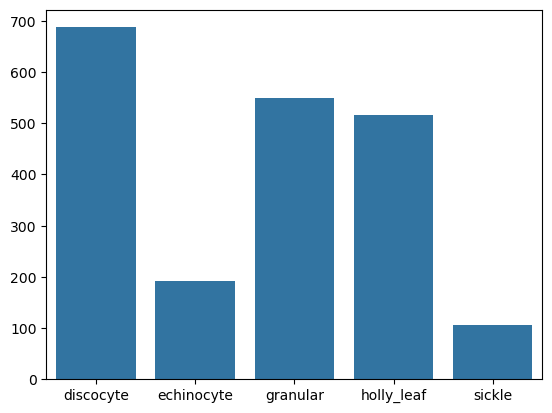

In [11]:
unique, counts = np.unique(y_test, return_counts=True)
sns.barplot(y=counts, x=unique)

In [13]:
path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262"
fnames = [path + "/" + image for image in os.listdir(path)]

In [15]:
X_test = []
for name in fnames:
    img = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
    X_test.append(img)
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255
X_test.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21683,) + inhomogeneous part.

In [ ]:
mobile_net = keras.models.load_model(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v1.keras"
)

2024-06-28 19:12:58.268383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 683 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_test)

LabelEncoder()

In [ ]:
y_pred_list = []

with tf.device("GPU:0"):
    y_pred = mobile_net.predict(X_test)
    y_pred = y_pred.argmax(axis=1)

In [ ]:
y_pred = le.inverse_transform(y_pred)

In [45]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)


accuracy = balanced_accuracy_score(y_test, y_pred)
f1_score_model = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
scores = {
    "test_balanced_accuracy": accuracy,
    "test_f1_weighted": f1_score_model,
    "test_precision_weighted": precision,
}
scores_df = pd.DataFrame(scores, index=[0])

In [46]:
scores_df

,test_balanced_accuracy,test_f1_weighted,test_precision_weighted
0,0.99574,0.997077,0.997081


In [47]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_pred, y_test):

    fig, ax = plt.subplots(figsize=(8, 8))

    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

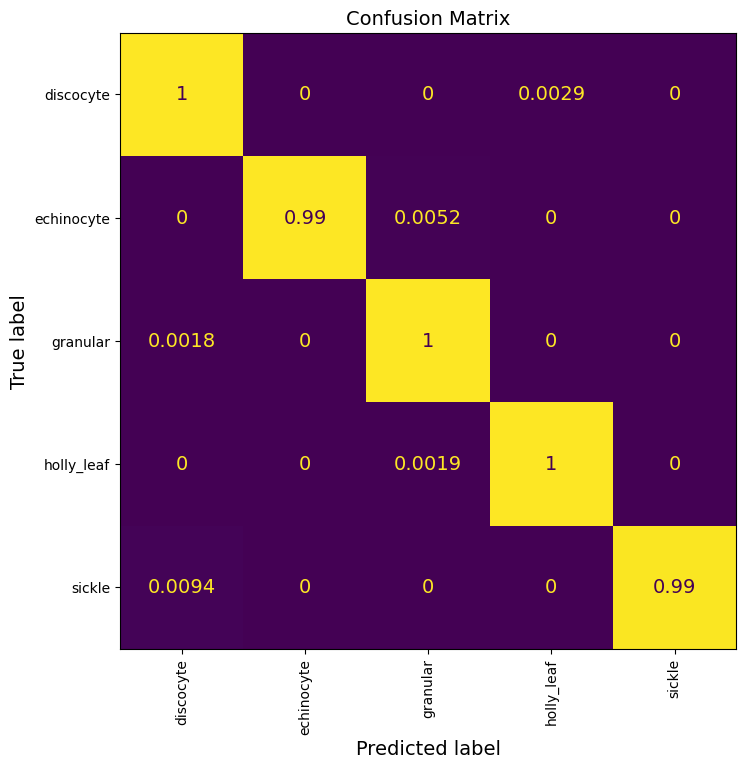

In [49]:
get_confusion_matrix(y_pred, y_test)

Predicting new cytopix images

In [68]:
dataset_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262"
fnames = [dataset_path + "/" + image for image in os.listdir(dataset_path)]

In [101]:
X = []
for name in fnames[5001:10000]:
    img = cv2.imread(os.path.join(dataset_path, name), cv2.IMREAD_GRAYSCALE)
    X.append(img)

X = np.expand_dims(X, axis=-1).astype(np.float32) / 255

In [102]:
len(X)

4999

In [103]:
y_pred = mobile_net.predict(X)
y_pred = y_pred.argmax(axis=1)
y_pred = le.inverse_transform(y_pred)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [104]:
len(y_pred)

4999

In [98]:
path_out = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_predicted_50001"

In [ ]:
for name, prediction in zip(fnames, y_pred):
    print("******")
    file_name = name.split("/")[-1]

    img = cv2.imread(os.path.join(dataset_path, name), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(os.path.join(path_out, prediction, file_name), img)